1. Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

In [1]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

In [2]:
from sklearn.datasets import load_diabetes

In [3]:
X, y = load_diabetes(return_X_y=True)

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [6]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg,
                          coef in zip(trees_list, coef_list)]) for x in X])

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [7]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y-z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z-y)$. Реализуем ее также в виде функции (коэффициент 2 можно отбросить).

In [8]:
def bias(y, z):
    return (y - z)

Реализуем функцию обучения градиентного бустинга.

In [9]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Построим графики зависимости ошибки на обучающей и тестовой выборках от числа деревьев.

In [10]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [38]:
def get_error_plot(n_trees, train_err, test_err, name_):
    plt.figure(figsize = (12, 7))

    plt.xlabel(name_)
    plt.ylabel('MSE')

    plt.yticks(np.arange(0, 30000, 2000))
    plt.xlim(0, n_trees[-1])

    plt.plot(n_trees, train_err, label='train error')
    plt.plot(n_trees, test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

In [34]:
# Число деревьев в ансамбле
n_trees = 30

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 5

# Шаг
eta = 0.1

In [31]:
n_trees_array = [1, 3, 5, 10, 20, 30, 50]

train_err = []
test_err  = []

for n_trees in n_trees_array:
    coefs = [1] * n_trees

    trees, train_error, test_error = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

    train_prediction = gb_predict(X_train, trees, coefs, eta)
    train_err.append(mean_squared_error(y_train, train_prediction))

    test_prediction = gb_predict(X_test, trees, coefs, eta)
    test_err.append(mean_squared_error(y_test, test_prediction))

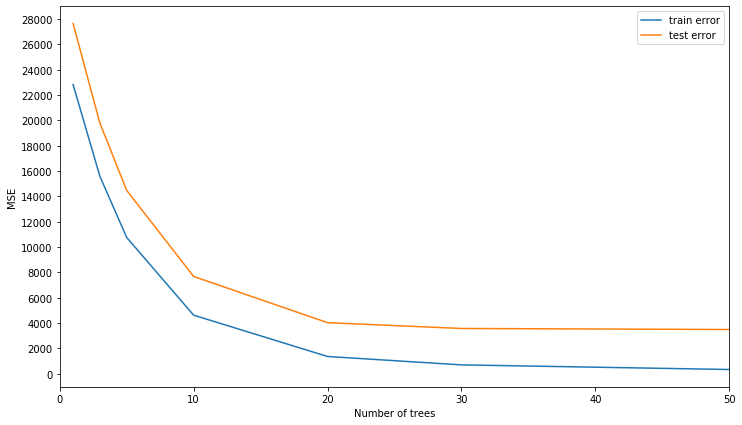

In [32]:
get_error_plot(n_trees_array, train_err, test_err, 'Number of trees')

In [36]:
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth_array = [1, 2, 3, 4, 5, 7, 8]

train_err = []
test_err  = []

for max_depth in max_depth_array:

    trees, train_error, test_error = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

    train_prediction = gb_predict(X_train, trees, coefs, eta)
    train_err.append(mean_squared_error(y_train, train_prediction))

    test_prediction = gb_predict(X_test, trees, coefs, eta)
    test_err.append(mean_squared_error(y_test, test_prediction))

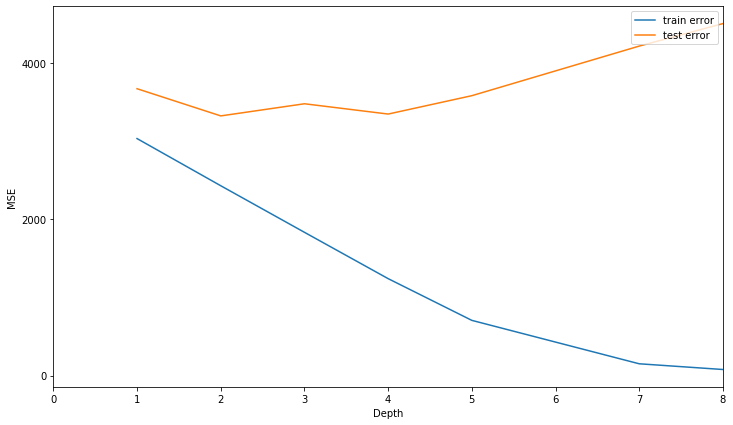

In [39]:
get_error_plot(max_depth_array, train_err, test_err, 'Depth')

#### с увеличением количества деревьев ошибка уменьшается, а с ростом глубины >2 деревья переобучаются

2*. Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.